In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import read_csv
sns.set_style('white')
sns.set_context('notebook', font_scale=1.75)
%matplotlib inline

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Load data.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

data = read_csv('data/moodRL_data.csv')
metadata = read_csv('data/moodRL_metadata.csv')
ratings = read_csv('data/moodRL_ratings.csv')

### Note: As of time of writing, analysis is being performed on incomplete dataset for pedagogical purposes. In other words, the plots below are not informative of the information presented in the original manuscript.

## Section 1: Sanity Checks

### Task performance & learning rates

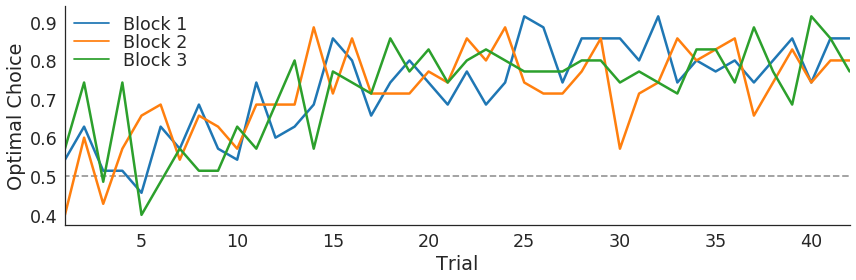

In [2]:
## Prepare data.
df = data[data.Block<4].copy()
df['Optimal'] = df.Choice == df[['M1','M2']].max(axis=1)
df.Block = ['Block %s' %s for s in df.Block]

## Plot.
fig, ax = plt.subplots(1,1,figsize=(12,4))
sns.lineplot('Trial', 'Optimal', 'Block', data=df, ci=None, lw=2.5, ax=ax)

## Add info.
ax.hlines(0.5, *ax.get_xlim(), linestyle='--', alpha=0.4)
ax.set(xlim=(1,42), ylabel='Optimal Choice')
ax.legend(loc=2, labelspacing=0, borderpad=0)

sns.despine()
plt.tight_layout()

### Subjective estimates of likelihood of win

/home/szoro/Documents/software/anaconda3.6/lib/python3.6/site-packages/seaborn/axisgrid.py:703: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/home/szoro/Documents/software/anaconda3.6/lib/python3.6/site-packages/seaborn/axisgrid.py:708: UserWarning: Using the pointplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


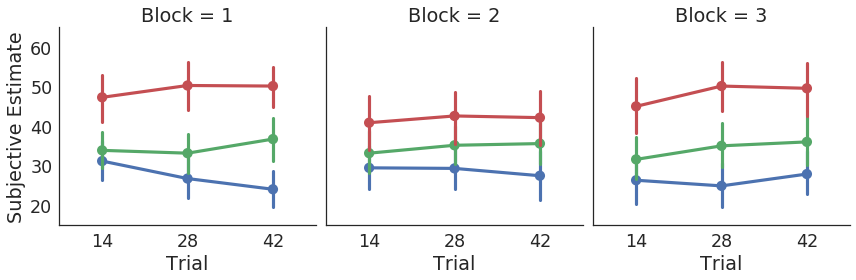

In [3]:
g = sns.FacetGrid(ratings[ratings.Variable!='Mood'], col='Block', size=4)
g.map(sns.pointplot, 'Trial', 'Rating', 'Variable', palette=['#4c72b0', '#55a868', '#c44e52'])
g.axes[0,0].set(ylim=(15,65), ylabel='Subjective Estimate');

### Wheel of fortune mood manipulation

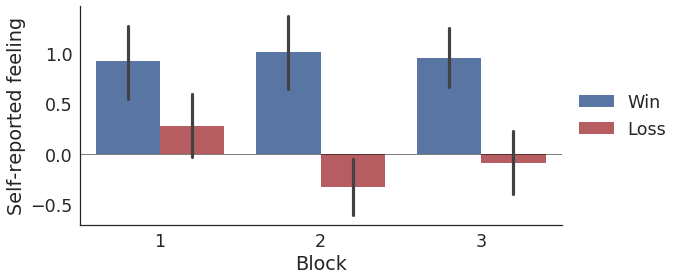

In [4]:

df = ratings.merge(metadata[['Subject','Datetime','WoF']], on=['Subject','Datetime'])
df['Outcome'] = np.where(df.WoF > 0, 'Win', 'Loss')

## Plot.
fig, ax = plt.subplots(1,1,figsize=(8,4))
sns.barplot('Block', 'Rating', 'Outcome', data=df[df.Variable=='Mood'], 
            palette=['#4c72b0', '#c44e52'], ax=ax)

## Add info.
ax.set(ylabel='Self-reported feeling')
ax.hlines(0,*ax.get_xlim(),lw=0.5)
ax.legend(loc=7, bbox_to_anchor=(1.25,0.5))

sns.despine()
plt.tight_layout()

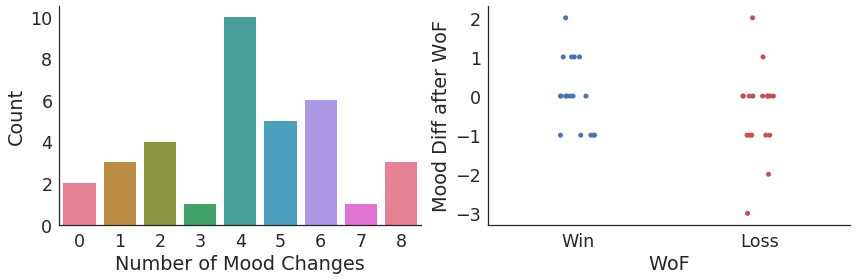

In [ ]:
df = ratings[ratings.Variable=='Mood'].groupby('Datetime')
df = df.Rating.apply(np.diff).reset_index()
df = df.merge(metadata[['Datetime','WoF']], on='Datetime')
df['Shifts'] = df.Rating.apply(np.count_nonzero)
df['Diff'] = df.Rating.apply(lambda arr: arr[2])

fig, axes = plt.subplots(1,2,figsize=(12,4))
sns.countplot('Shifts', data=df, palette=sns.color_palette('husl', n_colors=df.Shifts.max()), ax=axes[0])
axes[0].set(xlabel='Number of Mood Changes', ylabel='Count')

sns.stripplot('WoF', 'Diff', data=df, order=[7,-7], palette=['#4c72b0', '#c44e52'], 
              jitter=True, ax=axes[1])
axes[1].set(xticklabels=['Win','Loss'], ylabel='Mood Diff after WoF')

sns.despine()
plt.tight_layout()

## Section 2: Model Fitting

### Base model: traditional reinforcement learning

In [ ]:
import pystan

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Model parameters.
q = 0

## Sampling parameters.
model_name = 'moodRL_base.stan'
samples = 500
warmup = 375
chains = 4
thin = 1
    
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Prepare data.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Reduce DataFrame.
df = data[data.Block < 4].copy()

## Drop trials with missing data.
df = df[df.Choice.notnull()]

## Extract and prepare data.
X = df[['M1','M2']].values
Y = np.array([ np.argmax(x == y)+1 for x, y in zip(X, df.Choice.values) ])
R = df.Outcome.values

## Define metadata.
_, ix = np.unique(df.Datetime, return_inverse=True)
ix += 1
T = ix.size
N = ix.max()

## Organize data dictionary.
dd = dict(T=T, N=N, ix=ix, X=X, Y=Y, R=R, q=q)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Model fitting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
print('n_samples = %0.0f' %((samples - warmup) * chains / thin))

file = 'stan_models/%s' %model_name
fit = pystan.stan(file=file, data=dd, iter=samples, warmup=warmup, thin=thin,
                  chains=chains, seed=47404, n_jobs=1)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_0cb89dfa44d25d6cc5d89b702b14f83e NOW.


n_samples = 500
